F:\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


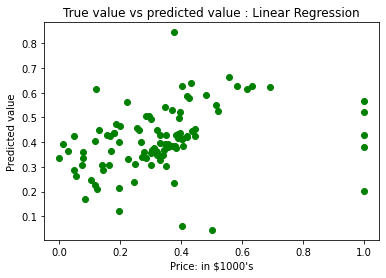

mse 0.22017696168875311
0.8415841584158416 score


In [2]:



import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt



header=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 
        'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv("housing.csv", names=header, delim_whitespace=True)#load data

X = df.drop(['MEDV'], axis=1)#the X all features except only 1 features which is the MEDV that represents(2D, as many features)
Y = df.MEDV#y is one feature, the house prices(1 coloumn)
for i in range(13):#normalization for x
    max_X=max(X.iloc[:,i])
    min_X=min(X.iloc[:,i])
    X.iloc[:,i]=(X.iloc[:,i]-min_X)/(max_X-min_X)

max_Y=max(Y.iloc[:])
min_Y=min(Y.iloc[:])
Y.iloc[:]=(Y.iloc[:]-min_Y)/(max_Y-min_Y)

def splitTT(X_norm, percentTrain): 
    
    np.random.shuffle(np.array(X_norm))
    pd.DataFrame(X_norm)
    # Get index to split the data and slice the dataset based on the index
    index = round(len(X_norm)*percentTrain)
    X_train, X_test = X_norm.iloc[:index,:], X_norm.iloc[index:,:]
    X_split = [X_train, X_test]
    return X_split

def splitTTY(Y_norm, percentTrain): #used to split the data with any % we want, for Y(1D matrices)
    # Split dataset into train and test set based on the percentTrain specified
    # Random shuffling of data before splitting
    np.random.shuffle(np.array(Y_norm))
    pd.DataFrame(Y_norm)
    # Get index to split the data and slice the dataset based on the index
    index = round(len(Y_norm)*percentTrain)
    Y_train, Y_test = Y_norm.iloc[:index], Y_norm.iloc[index:]
    Y_split = [Y_train, Y_test]
    return Y_split
#split the data to 60% train, 20% cv, 20% test
X_train,X_test1=splitTT(X,0.6)
X_test,X_cv=splitTT(X_test1,0.5)
Y_train,Y_test1=splitTTY(Y,0.6)
Y_test,Y_cv=splitTTY(Y_test1,0.5)

def rmse(y_test, y_pred):#calc. the root mean square error(difference bet y calc. and y we know)
    N = len(y_test)
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    mse = np.sum((y_test - y_pred)**2) / (2*N) 
    rmse = np.sqrt(mse)
    return rmse
#the rmse_lamda calc. the root mean square error(difference bet y calc. and y we know) but with different rule that has lamda 
def rmse_lamda(y_test, y_pred,theta0,theta1):#regularization, returns lamda with least cost
    cost_reg=100
    best_lamda=0
    lamda=np.array([0.01,0.02,0.04,0.08,0.16,0.32,0.64,1.28,2.56,5.12,10.24])
    N = len(y_test)
    for l in range(np.size(lamda)):#calc cost with diff lamda to get the one with least cost
        y_test = np.array(y_test)
        y_pred = np.array(y_pred)
        mse = (np.sum((y_test - y_pred)**2) / (2*N))+(lamda[l]/2*N)*((np.sum(theta1**2))+theta0**2) 
        rmse = np.sqrt(mse)
        if rmse<cost_reg:#compare each loop to save the min. cost value
            cost_reg=rmse
            best_lamda=lamda[l]
    return rmse,best_lamda

def gradient_descent(X, y, a = 0.02, epoch = 1000): #a=learning rate 
    dim = len(X.columns)
    # Initialise a random bias/beta0 (represented by b) and weights for the regression equation 
    b = np.random.random()#theta0
    weights = np.random.rand(dim)#rest of thetas
    for e in range(0, epoch+1):
        # Calculate the predicted values of y 
        y_hat = b + np.dot(X, weights) #calc. hypothesis with initial thetas
        # Calculate and log RSME and R squared
        root_rmse = rmse(y, y_hat) #calc. hypothesis cost
        # Update theta0=b,and weights(rest thetas)
        b = b - a*((np.sum(y_hat - y)*2)/len(y)) #update theta0
        weights = weights - a*((np.dot((y_hat-y),X)*2)/len(y))#update rest thetas
    return y_hat, b, weights,root_rmse
cost_cv=100
theta0_cv=0
theta1_cv=np.zeros(13)
for j in range(13):#cross_validation with best alpha to get the best hypothesis order
    #use the gradient descent to calc. each hypothesis oredr and get the best thetas for it
    y_hat, theta0, theta1,root_rmse=gradient_descent(X_train.iloc[:,0:j], Y_train, a=0.02 , epoch = 1000)
    #calc the hypothesis using X cross validtion and thetas resulted from gard. descent
    y_pred= theta0 + np.dot(X_cv.iloc[:,0:j], theta1)
    root_cv=rmse(Y_cv,y_pred)#calc. cost between y_pred an dy_cv we already know
    root_reg,lamda_best=rmse_lamda(Y_cv, y_pred,theta0,theta1)#calc. cost between y_pred an dy_cv we already know but with lamda used in cost function
    if root_cv<cost_cv:#save the minimum cost with coressponding thetas and hypothesis order(length thetas)
        cost_cv=root_cv
        theta0_cv=theta0
        theta1_cv[0:j]=theta1
    if root_reg<cost_cv:
        cost_cv=root_reg
        theta0_cv=theta0
        theta1_cv[0:j]=theta1
#test the data using the X test and y test and calculate the accuracy of the model
y_pred_test=theta0_cv+np.dot(X_test.iloc[:,0:np.size(theta1_cv)], theta1_cv)
cost_Y_test=rmse(Y_test, y_pred_test)#cost using rmse
cost_test_reg=rmse(Y_test, y_pred_test)+(lamda_best/2*101)*((np.sum(theta1_cv**2))+theta0_cv**2)#cost using rmse with lamda best 

#plot y test (that we know) and y pred that is calc. using our model
plt.scatter(Y_test, y_pred_test, c = 'green') 
plt.xlabel("Price: in $1000's")
plt.ylabel("Predicted value")
plt.title("True value vs predicted value : Linear Regression")
plt.show()



from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

print('mse', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_test)))
print(accuracy_score(np.round(Y_test), np.round((pd.DataFrame(y_pred_test)))),'score' )#score of the model, difference between y test (that we know) and y pred that is calc. using our model

